# Train classifier for P5 vehicle finding

**Author: olala7846@gmail.com**

## Step 1: observe training data

In [14]:
# first do some training data observation
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random


vehicle_imgs = list(glob.glob('./vehicles/**/*.png'))
nonvehicle_imgs = list(glob.glob('./non-vehicles/**/*.png'))

print('Total %d vehicle images' % len(vehicle_imgs))
print('Total %d non-vehicle images' % len(nonvehicle_imgs))
print('There are about the same size of both classes')

sample_img = random.sample(vehicle_imgs, 1)[0]
img = cv2.imread(sample_img)
print('images has shape', img.shape, 'and dtype', img.dtype)
print('Pixel value range approximately from', np.max(img), 'to', np.min(img))

Total 8792 vehicle images
Total 8968 non-vehicle images
There are about the same size of both classes
images has shape (64, 64, 3) and dtype uint8
Pixel value range approximately from 252 to 9


## Step 2: plot and see how training data distributed on different color spaces

In [15]:
# Explore different color space
from mpl_toolkits.mplot3d import Axes3D

convertors = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb,
    'Lab': cv2.COLOR_BGR2Lab,
    'Luv': cv2.COLOR_BGR2Luv,
}

def plot3d(car_pixels, non_car_pixels):
    """Plot pixels in 3D"""
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    all_pixels = np.vstack((car_pixels, non_car_pixels))

    # Set axis limits
    ax.set_xlim(np.min(all_pixels[:, 0]), np.max(all_pixels[:, 0]))
    ax.set_ylim(np.min(all_pixels[:, 1]), np.max(all_pixels[:, 1]))
    ax.set_zlim(np.min(all_pixels[:, 2]), np.max(all_pixels[:, 2]))

    ax.scatter(
        car_pixels[:, 0].ravel(),
        car_pixels[:, 1].ravel(),
        car_pixels[:, 2].ravel(),
        c='g', edgecolors='none')

    ax.scatter(
        non_car_pixels[:, 0].ravel(),
        non_car_pixels[:, 1].ravel(),
        non_car_pixels[:, 2].ravel(),
        c='r', edgecolors='none')
    
    return ax

def observe_colorspace():
    sample_car_imgs = random.sample(vehicle_imgs, 100)
    sample_noncar_imgs = random.sample(nonvehicle_imgs, 100)

    for name, convertor in convertors.items():
        car_pixels = []
        noncar_pixels = []

        samples_per_pic = 10

        for car_img in sample_car_imgs:
            img = cv2.imread(car_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            car_pixels.append(sample_pixels)

        for noncar_img in sample_noncar_imgs:
            img = cv2.imread(noncar_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            noncar_pixels.append(sample_pixels)

        car_pixels = np.vstack(car_pixels)
        noncar_pixels = np.vstack(noncar_pixels)

        ax = plot3d(car_pixels, noncar_pixels)
        plt.title(name)
       # plot different view points
        for ii in range(0,360,5):
            ax.view_init(elev=10., azim=ii)
            plt.savefig("./color_spaces/%s%d.png" % (name, ii))
        
#observe_colorspace()

## Step3: Feature extraction

reading  ./vehicles/GTI_Far/image0000.png
(96,)


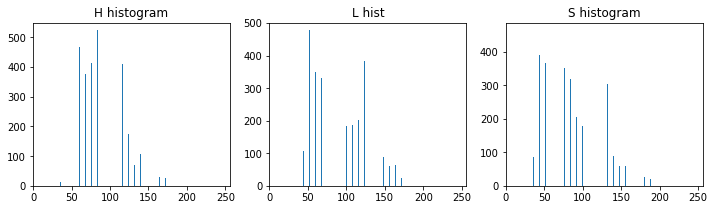

In [26]:
# Extact color histogram features

def color_hist(img, nbins=32, bins_range=(0, 256), visualize=False):
    channel1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    if visualize:
        print(features.shape)
        return features, (channel1, channel2, channel3)
    else:
        return features
    
img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])

features, histograms = color_hist(img, visualize=True)
hist1, hist2, hist3 = histograms

# visualize histogram
# calculate bin center
bin_edges = hist1[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, hist1[0])
plt.xlim(0, 256)
plt.title('H histogram')
plt.subplot(132)
plt.bar(bin_centers, hist2[0])
plt.xlim(0, 256)
plt.title('L hist')
plt.subplot(133)
plt.bar(bin_centers, hist3[0])
plt.xlim(0, 256)
plt.title('S histogram')
plt.show()

In [27]:
# Extract spatial bin features

def bin_spatial(img, size=(32, 32)):
    resize_img = cv2.resize(img, size)
    color1 = resize_img[:,:,0].ravel()
    color2 = resize_img[:,:,1].ravel()
    color3 = resize_img[:,:,2].ravel()
    features = np.hstack((color1, color2, color3))
    return features

img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])
features = bin_spatial(img)
print(features.shape)

reading  ./vehicles/GTI_Far/image0000.png
(3072,)


(7, 7, 2, 2, 9)


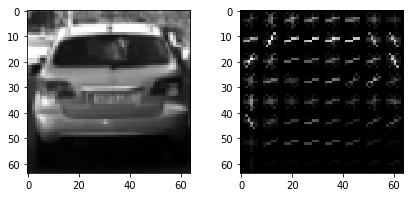

In [28]:
# Extract hog features
from skimage.feature import hog

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=vis, feature_vector=feature_vec)


img = cv2.imread(random.sample(vehicle_imgs, 1)[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(gray, vis=True)
print(features.shape)
fig = plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.show()

## Step4: Train classifier on features

In [30]:
# Test training on color histogram features
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time


def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = color_hist(cvt_img)
    return features

def train_with_color_hist(cspace):
    # extract features
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('Finished training after %d seconds' % round(t2-t1, 2))
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

for key in convertors:
    train_with_color_hist(cspace=key)

training Luv
(17760, 96) (17760,)
Finished training after 2 seconds
Test Accuracy of SVC =  0.911036036036
training YCrCb
(17760, 96) (17760,)
Finished training after 3 seconds
Test Accuracy of SVC =  0.926238738739
training RGB
(17760, 96) (17760,)
Finished training after 3 seconds
Test Accuracy of SVC =  0.912725225225
training HLS
(17760, 96) (17760,)
Finished training after 3 seconds
Test Accuracy of SVC =  0.947072072072
training Lab
(17760, 96) (17760,)
Finished training after 2 seconds
Test Accuracy of SVC =  0.942286036036
training YUV
(17760, 96) (17760,)
Finished training after 2 seconds
Test Accuracy of SVC =  0.911317567568


### Result training SVM with color_hist on different color spaces
#### single color space: 96 features
| RGB    | HLS    | YUV    | YCrCb  | Lab    | Luv    |
|--------|--------|--------|--------|--------|--------|
| 0.9003 | 0.9470 | 0.9234 | 0.9214 | 0.9456 | 0.9107 |

#### double color space: 192 features
| HLS + YUV | YUV + Lab | RGB + Luv | RGB + YCrCb | YCrCb + Luv |
|-----------|-----------|-----------|-------------|-------------|
| 0.9513    | 0.9488    | 0.9400    | 0.9414      | 0.9335      |

Tooks around 4 seconds to train on all data

In [31]:
# Test training on bin_spatial features with SVM
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time


def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    features = bin_spatial(cvt_img)
    return features


def train_with_bin_hist(cspace='RGB'):
    print(cspace, ':')
    # extract features
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # define labels
    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('Finished training after %d seconds' % round(t2-t1, 2))
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
    
# train_with_bin_hist()
for key in convertors:
    train_with_bin_hist(cspace=key)

training Luv
(17760, 3072) (17760,)
Finished training after 32 seconds
Test Accuracy of SVC =  0.897240990991
training YCrCb
(17760, 3072) (17760,)
Finished training after 34 seconds
Test Accuracy of SVC =  0.905405405405
training RGB
(17760, 3072) (17760,)
Finished training after 41 seconds
Test Accuracy of SVC =  0.906813063063
training HLS
(17760, 3072) (17760,)
Finished training after 31 seconds
Test Accuracy of SVC =  0.878941441441
training Lab
(17760, 3072) (17760,)
Finished training after 27 seconds
Test Accuracy of SVC =  0.913288288288
training YUV
(17760, 3072) (17760,)
Finished training after 35 seconds
Test Accuracy of SVC =  0.912162162162


### Result training SVM with bin_spatial on different color spaces
####  (16x16) single color space: 96 features  (took around 17 seconds to train)
| RGB    | HLS    | YUV    | YCrCb  | Lab    | Luv    |
|--------|--------|--------|--------|--------|--------|
| 0.9183 | 0.8978 | 0.9155 | 0.9133 | 0.9240 | 0.9223 |

####  (8x8) single color space: 96 features  (took around 8 seconds to train)
| RGB    | HLS    | YUV    | YCrCb  | Lab    | Luv    |
|--------|--------|--------|--------|--------|--------|
| 0.8989 | 0.8612 | 0.9040 | 0.9009 | 0.9091 | 0.9023 |

In [33]:
# Test training on bin_spatial features with SVM
def extract_features(img, cspace='RGB'):
    img = cv2.imread(img)
    convertor = convertors[cspace]
    cvt_img = cv2.cvtColor(img, convertor)
    channel1 = get_hog_features(cvt_img[:,:,0]).ravel()
    channel2 = get_hog_features(cvt_img[:,:,1]).ravel()
    channel3 = get_hog_features(cvt_img[:,:,2]).ravel()

    return np.concatenate((channel1, channel2, channel3))


def train_with_hog_features(cspace='RGB'):
    print(cspace, ':')
    car_features = np.array([extract_features(img, cspace=cspace) for img in vehicle_imgs])
    noncar_features= np.array([extract_features(img, cspace=cspace) for img in nonvehicle_imgs])

    # define labels
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)),
                   np.zeros(len(noncar_features))))

    # train test split
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('Finished training after %d seconds' % round(t2-t1, 2))
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
    
for key in convertors:
    train_with_hog_features(cspace=key)

Luv
Finished training after 31 seconds
Test Accuracy of SVC =  0.983952702703
YCrCb
Finished training after 21 seconds
Test Accuracy of SVC =  0.987894144144
RGB
Finished training after 24 seconds
Test Accuracy of SVC =  0.969031531532
HLS
Finished training after 20 seconds
Test Accuracy of SVC =  0.98170045045
Lab
Finished training after 15 seconds
Test Accuracy of SVC =  0.985078828829
YUV
Finished training after 17 seconds
Test Accuracy of SVC =  0.98704954955


## Some experiment on HOG features
| Color space | Accuracy |
|-------------|----------|
| Gray        | 0.9555   |
| H(HLS)      | 0.9203   |
| L(HLS)      | 0.9484   |
| S(HLS)      | 0.9031   |
| Y(YUV)      | 0.9527   |
| U(YUV)      | 0.9304   |
| V(YUV)      | 0.9020   |
| Y(YCrCb)    | 0.9518   |
| Cr(YCrCb)   | 0.9256   |
| Cb(YCrCb)   | 0.9090   |
| YCrCb(All)  | 0.9887   |

| Color space | Accuracy |
|-------------|----------|
| RGB(All)    | 0.9653   |
| HLS(All)    | 0.9828   |
| YUV(All)    | 0.9882   |
| YCrCb(All)  | 0.9884   |
| Lab(All)    | 0.9870   |
| Luv(All)    | 0.9825   |


## Step 5: Combine all features



In [9]:
# feature selection
from sklearn.feature_selection import SelectFromModel
import time


def extract_features(img, color_space='Luv'):
    img = cv2.imread(img)
    yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    channel1 = get_hog_features(yuv_img[:,:,0]).ravel()
    channel2 = get_hog_features(yuv_img[:,:,1]).ravel()
    channel3 = get_hog_features(yuv_img[:,:,2]).ravel()

    return np.concatenate((channel1, channel2, channel3))

car_features = np.array([extract_features(img) for img in vehicle_imgs])
noncar_features= np.array([extract_features(img) for img in nonvehicle_imgs])

# define features
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
# define labels
y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(noncar_features))))
print(X.shape, y.shape)

(17760, 1728) (17760,)


## Feature selection using devision tree
from 8460 features to 139 features

In [10]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

t = time.time()
svc1 = LinearSVC()
svc1.fit(X_train, y_train)
t2 = time.time()
print('Test Accuracy of SVC1 = ', svc1.score(X_test, y_test))
t3 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(round(t3-t2, 2), 'Seconds to score SVC...')

# tree_clf = DecisionTreeClassifier()
# tree_clf.fit(X_train, y_train)

# print('Feature selection with decision tree')
# feature_select = SelectFromModel(tree_clf, prefit=True)
# X_train_new = feature_select.transform(X_train)
# X_test_new = feature_select.transform(X_test)
# print(X_train.shape)
# print(X_train_new.shape)

# t = time.time()
# svc2 = LinearSVC()
# svc2.fit(X_train_new, y_train)
# t2 = time.time()
# print('Test Accuracy of SVC2 = ', svc2.score(X_test_new, y_test))
# t3 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC2...')
# print(round(t3-t2, 2), 'Seconds to score SVC...')

Test Accuracy of SVC1 =  0.981981981982
5.19 Seconds to train SVC...
0.01 Seconds to score SVC...


In [11]:
import pickle
data = {
#     'feature_select': feature_select,
    'classifier1': svc1,
#     'classifier2': svc2,
    'X_scaler': X_scaler,
}

print(X_scaler)
print(svc1)

filename = 'classifier.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data, f)

StandardScaler(copy=True, with_mean=True, with_std=True)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
